# 1. Décomposition $f_b$ $f_h$ pour BoT

On part de l'équation cinétique suivante :

$$ \partial_t f + v\partial_x f + E\partial_v f = 0 $$

le champ $E$ peut être évalué soit via l'équation de Poisson ou d'Ampère, et la condition initiale est celle d'un bump on tail.

Première chose que l'on effectue est une décomposition de $f = f_b + f_h$ correspondant à :

* $f_b$ est l'ensemble des particules froides formant la majorité de la masse du problème (bulk)
* $f_h$ est l'ensemble des particules chaudes (hot)

Le problème peut se décomposer comme suit :

$$
  \begin{cases}
    \partial_t f_b + v\partial_x f_b + E\partial_v f_b = 0 \\
    \partial_t f_h + v\partial_x f_h + E\partial_v f_h = 0
  \end{cases}
$$

Il est à noter que le champ électrique $E$ est le même pour les deux équations (qui sont donc couplées) et qu'il est calculé à partir de la densité totale $\rho = \int f_b+f_h\,\mathrm{d}v$.

> On remarque qu'un couple de fonction $f_b$ et $f_h$ vérifiant l'équation induite par cette décomposition vérifiera l'équation cinétique, mais cela n'indique pas comment calculer $f_b$ et $f_h$. Il est fort probable que tout couple de fonctions $(f_1,f_2)$ tel que $f = f_1+f_2$ ne vérifie pas nécessairement cette décomposition.
On se retrouve à devoir résoudre 2 équations cinétiques, la première idée a été d'effectuer du mM sur $f_b$ et de ne l'approximer qu'à sa partie macro. Cela ne fonctionne pas nécessairement très bien car la décomposition mM impose d'avoir $\int g\,\mathrm{d}v = 0$, or le cas du bump on tail, la bosse rajoutée sur la queue n'est pas de masse nulle.

Pour résoudre une des équations cinétiques on peut effectuer une transformée de Fourier en $x$ puis effectuer un schéma exponentielle type RK3 exponentiel (IFRK3 pour integrating factor Runge-Kutta method) ou Lawson pour résoudre le problème en temps. La résolution via une FFT est envisageable en espace grâce à des conditions aux bords périodiques en espace (ce qui était déjà fait pour la résolution de l'équation de Poisson). En vitesse, la modélisation informatique utilise des conditions aux bords périodiques mais il ne s'agit pas là d'une réalité de la modélisation mathématique ; de plus il serait intéressant de restreindre le domaine en vitesse pour une seule des équations, donc l'aspect périodique du domaine perd tout son sens.

Partons de l'équation cinétique, effectuons une transformée de Fourier uniquement en $x$ et étudions le mode $\kappa$ de la transformée :

$$
  \partial_t \hat{f} + vi\kappa\hat{f} + \widehat{(E\partial_v f)} = 0
$$

De la même manière que cela a été proposée pour résoudre l'équation avec le terme raide de collision, on peut rassembler la dérivée temporelle avec celle en espace dans un seul terme :

$$
  \partial_t(e^{vi\kappa t}\hat{f}) = -e^{vi\kappa t}(\widehat{E\partial_v f})
$$

Équation que l'on peut résoudre à l'aide d'un schéma IFRK3 ou de Lawson :

$$
  \hat{f}(t^{n+1}) = e^{-vi\kappa\Delta t}\hat{f}(t^n) - \int_{t^n}^{t^{n+1}} e^{vi\kappa(t-t^{n+1})}(\widehat{E\partial_vf})(t)\,\mathrm{d}v
$$

Seul le terme $E\partial_vf$ est résolu à l'aide d'un schéma WENO :

$$
  E\partial_vf \approx \frac{E}{\Delta v}\left(f^W_{k+\frac{1}{2}}-f^W_{k-\frac{1}{2}}\right)
$$

> Cette FFT s'explique pour des raisons de CFL, en effet la CFL d'un schéma WENO sur l'équation cinétique met en jeu les termes $\frac{v_{max}}{\Delta x}$ et $\frac{E_{max}}{\Delta v}$ or c'est ce premier qui est contraignant car impose indirectement une certaine grille en vitesse (via $v_{max}$) tout en contraignant la grille en espace. On s'affranchit donc ici, grace à une FFT de la CFL en espace pour ne conserver qu'une CFL dû à un champ électrique qui n'est pas prépondérant.

---

Nous allons ici dans un premier temps estimer la condition CFL du couple de schéma WENO-RK3.

# 2. Interprétation géométrique de la CFL

Nous nous intéressons ici à résoudre un problème type de la forme :

$$
  \partial_t u + \partial_x f(u) = 0
$$

On utilise l'interprétation géométrique de la CFL, et on se base sur le papier de Wang et Spiteri pour effectuer ce calcul sur le schéma WENO et étudier la stabilité de différents couples de schéma temps-espace.

In [1]:
"""
global import, and define symbols
"""

import numpy as np
import matplotlib.pyplot as plt

import sympy as sp
from sympy import I
sp.init_printing(use_latex='mathjax')

phi      = sp.symbols("\\phi",real=True) #,positive=True)
dx,dv,dt = sp.symbols("\\Delta\\ x \\Delta\\ v \\Delta\\ t",real=True,positive=True)
sig      = sp.symbols("\\sigma",real=True,positive=True)
x = sp.symbols("x",real=True)

"""
dummy class to store data
"""
class Data(object):
  pass
data = Data()

## 2.1 Courbe pour le schéma WENO

Dans un premier temps nous souhaitons tracer une fonction $\lambda^W(\phi)$ correspondant à l'analyse de von Neumann sur le schéma WENO. La courbe $\lambda^W(\phi)$ correspond au cas où l'expression dans l'analyse de von Neumann est égale à 1.

In [2]:
"""
symbols specific to WENO scheme
"""

e0,e1,e2 = sp.symbols("\\epsilon_0 \\epsilon_1 \\epsilon_2",real=True)
e3,e4,e5 = sp.symbols("\\epsilon_3 \\epsilon_4 \\epsilon_5",real=True)

w0 = sp.Rational(1,10) + e0
w1 = sp.Rational(6,10) + e1
w2 = sp.Rational(3,10) + e2

w3 = sp.Rational(1,10) + e3
w4 = sp.Rational(6,10) + e4
w5 = sp.Rational(3,10) + e5

def f(k):
  if k==0:
    return sp.symbols("f_j")
  return sp.symbols("f_j%+d"%k)
  
def stencil(i_min,i_max) :
    return dict(enumerate([ f(i) for i in range(i_min,i_max+1) ],start=i_min))
f_stencil = stencil(-3,3)

def symbols_to( stencil , func ):
  """
    symbols_to
    convert dictionary `stencil` of `int => sp.Symbols` to dictionary of `sp.Symbols => sp.Symbols`
    useful to replace all $f_i$ symbols by an other value in expression
  """
  r = {}
  for j,f in stencil.items():
    r[f] = func(j,f)
  return r

def symbols_to_vonNeumann( stencil ):
  """
    symbols_to_vonNeumann
    convert all $f_i$ symbols to equivalent in von Neumann analysis with exponential
    $\phi$ symbol need to be initialized
  """
  return symbols_to( stencil , lambda j,_:sp.exp(I*j*phi) )

In [3]:
"""flux WENO"""
fluxp = (w0*( sp.Rational(2,6)*f(-2) - sp.Rational(7,6)*f(-1) + sp.Rational(11,6)*f(+0) )
       + w1*(-sp.Rational(1,6)*f(-1) + sp.Rational(5,6)*f(+0) +  sp.Rational(2,6)*f(+1) )
       + w2*( sp.Rational(2,6)*f(+0) + sp.Rational(5,6)*f(+1) -  sp.Rational(1,6)*f(+2) ))

fluxm = (w3*( sp.Rational(2,6)*f(-3) - sp.Rational(7,6)*f(-2) + sp.Rational(11,6)*f(-1) )
       + w4*(-sp.Rational(1,6)*f(-2) + sp.Rational(5,6)*f(-1) +  sp.Rational(2,6)*f(+0) )
       + w5*( sp.Rational(2,6)*f(-1) + sp.Rational(5,6)*f(+0) -  sp.Rational(1,6)*f(+1) ))

flux = fluxp-fluxm

ztilde = flux.expand().subs({e0:0,e1:0,e2:0,e3:0,e4:0,e5:0})
M = (flux-ztilde).expand().collect([e0,e1,e2,e3,e4,e5])

ztilde_vN = ztilde.subs(symbols_to_vonNeumann(f_stencil))
M_vN = M.subs(symbols_to_vonNeumann(f_stencil))

On va vouloir étudier les données $\tilde{z}$ et $M$. Ces variables sont issues de la décomposition de $\lambda^Z(\phi) = \tilde{z}(\phi) + M(\phi)$ avec $M$ comportant tous les $(\epsilon_i)_{i=0,\dots,5}$, et $\tilde{z}$ le reste (ce qui correspond à l'approximation de $\lambda^W$ au premier ordre, en effet, on verra que $M = \mathcal{O}(\Delta x^2)$, par conséquent on supposera que l'étude de $\tilde{z} suffit à l'étude de WENO).

In [4]:
(ztilde,ztilde_vN)

⎛                                                2⋅ⅈ⋅\phi    ⅈ⋅\phi           
⎜f_j   f_j+1   f_j+2           f_j-2   f_j-3    ℯ           ℯ         1    -ⅈ⋅
⎜─── + ───── - ───── - f_j-1 + ───── - ─────, - ───────── + ─────── + ─ - ℯ   
⎝ 3      2       20              4       30         20         2      3       

        -2⋅ⅈ⋅\phi    -3⋅ⅈ⋅\phi⎞
\phi   ℯ            ℯ         ⎟
     + ────────── - ──────────⎟
           4            30    ⎠

In [5]:
(M,M_vN)

⎛                                                                             
⎜          ⎛11⋅f_j   7⋅f_j-1   f_j-2⎞             ⎛5⋅f_j   f_j+1   f_j-1⎞     
⎜\epsilon₀⋅⎜────── - ─────── + ─────⎟ + \epsilon₁⋅⎜───── + ───── - ─────⎟ + \e
⎝          ⎝  6         6        3  ⎠             ⎝  6       3       6  ⎠     

                                                                              
        ⎛f_j   5⋅f_j+1   f_j+2⎞             ⎛  11⋅f_j-1   7⋅f_j-2   f_j-3⎞    
psilon₂⋅⎜─── + ─────── - ─────⎟ + \epsilon₃⋅⎜- ──────── + ─────── - ─────⎟ + \
        ⎝ 3       6        6  ⎠             ⎝     6          6        3  ⎠    

                                                                              
         ⎛  f_j   5⋅f_j-1   f_j-2⎞             ⎛  5⋅f_j   f_j+1   f_j-1⎞      
epsilon₄⋅⎜- ─── - ─────── + ─────⎟ + \epsilon₅⋅⎜- ───── + ───── - ─────⎟, \eps
         ⎝   3       6        6  ⎠             ⎝    6       6       3  ⎠      

      ⎛        -ⅈ⋅\phi    -2⋅ⅈ⋅\phi⎞             

In [6]:
# phi array to store angle where evaluate ztilde(phi)
data.phi = np.linspace(0,2.0*np.pi,1000)

### 2.1.1 Coefficients de $M$

$M$ représente la partie avec les $(\epsilon_j)_{j\in[0,\cdots,5]} = \mathcal{O}(\Delta x^2)$.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


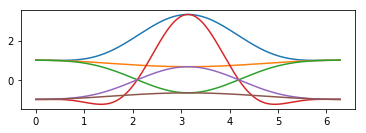

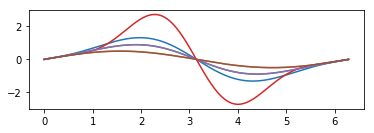

In [7]:
data.reMargs = []
data.imMargs = []
for arg in M_vN.args:
  re = sp.lambdify(phi,sp.re(arg.subs({e0:1,e1:1,e2:1,e3:1,e4:1,e5:1})),'numpy')(data.phi)
  im = sp.lambdify(phi,sp.im(arg.subs({e0:1,e1:1,e2:1,e3:1,e4:1,e5:1})),'numpy')(data.phi)
  data.reMargs.append(re)
  data.imMargs.append(im)
  plt.figure(1)
  plt.subplot(211)
  plt.plot(data.phi,re)
  plt.figure(2)
  plt.subplot(212)
  plt.plot(data.phi,im)
  
plt.show()

Chaque coefficient en $\epsilon_i$ dans le plan complexe maintenant, chacun de ces coefficients est en $\mathcal{O}(\Delta x^2)$. On remarque que l'on peut tous les majorer tranquillement par un cercle ($re^{i\phi}$ avec $r\approx 3\mathcal{O}(\Delta x^2)$).

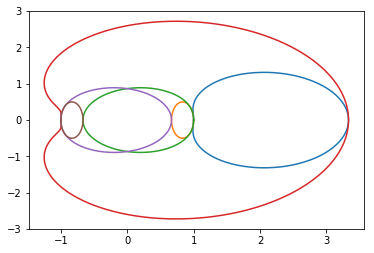

In [8]:
for i in range(len(data.reMargs)):
  plt.plot(data.reMargs[i],data.imMargs[i])
plt.show()

Maintenant on somme tous ces coefficients (à noter qu'ici on suppose $\epsilon_i=1\,i=0,\dots,5$).

Je ne suis pas certain que ce résultat soit pertinent

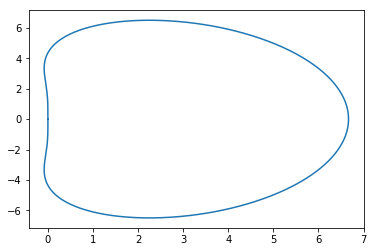

In [9]:
plt.plot(sum(data.reMargs),sum(data.imMargs))
#plt.xlim([-0.1,0])
plt.show()

### 2.1.2 Coefficients $\tilde{z}$

$\tilde{z}$ est la partie constante de $\lambda^W(\phi)$ (c'est-à-dire ne dépendant pas des $(\epsilon_j)_{j\in[0,\cdots,5]}$. C'est la partie principale, la valeur exacte de $\lambda^W(\phi)$ peut être interprété comme la valeur de $\tilde{z} + \mathcal{O}(\Delta x^2)$.

Donc en prenant $\Delta x$ suffisamment petit, $\lambda^W(\phi) \xrightarrow{\Delta x \to 0} \tilde{z}(\phi)$.

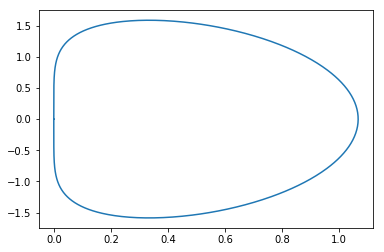

In [10]:
data.rez = sp.lambdify(phi,sp.re(ztilde_vN),'numpy')(data.phi)
data.imz = sp.lambdify(phi,sp.im(ztilde_vN),'numpy')(data.phi)

plt.plot(data.rez,data.imz)
#plt.plot(0.01*sum(data.reMargs),0.01*sum(data.imMargs))
plt.show()

J'interprète le résultat avec $M$ comme le fait que l'on va chatouiller notre courbe $\tilde{z}(\phi)$ par un petit $M(\phi)$, on peut ainsi tracer une telle courbe $\tilde{z}(\phi) + 0.01M(\phi)$

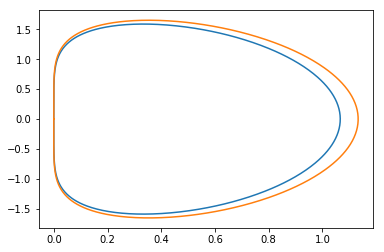

In [11]:
plt.plot(data.rez,data.imz)
c = 0.01
plt.plot(data.rez+c*sum(data.reMargs),data.imz+c*sum(data.imMargs))
plt.show()

Il faut retenir que `0.01` est une très grande valeur pour $\mathcal{O}(\Delta x^2)$. Cela ne change pas l'allure de la courbe, on modifie surtout l'élongation au niveau de la pointe de l'*œuf*, or la CFL générale (vu en bas) est limitée par la largeur de l'œuf.

L'impact de $M$ doit être gardé à l'esprit car il n'est pas possible d'évoquer un nombre de CFL dans l'absolu pour le couple RK3-WENO (là où il l'était pour le couple Euler-WENO, mais celui-ci était nul).

## 2.2 Courbe pour RK3

On s'intéresse ici au polynôme caractéristique du schéma RK3. On sait que le polynôme caractéristique d'un schéma RK$N$ (en tout cas pour un schéma *standard*) est une troncature de la série entière de l'exponentielle, donc de la forme :

$$
  p_N(z) = \sum_{n=0}^N \frac{z^n}{n!}
$$

Il est ensuite nécessaire de tracer la courbe d'équation $|p_N(z)| = 1$, pour cela Miguel m'a proposé de résoudre dans un premier temps l'équation :

$$
  p_N(z) = e^{i\theta}
$$

à $\theta$ fixé, on a ainsi trois solutions $(b_0(\theta),b_1(\theta),b_2(\theta))$. Puis ensuite faire varier $\theta \in [0,2\pi[$. On obtient ainsi 3 courbes paramétriques que l'on peut tracer sans trop de problèmes.

Puisque nous nous intéressons à RK3 on prendra par la suite $N=3$.

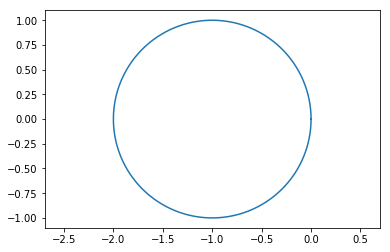

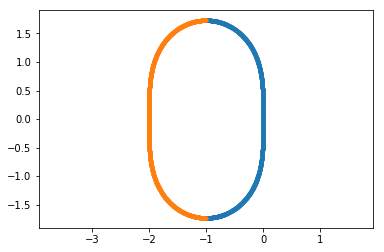

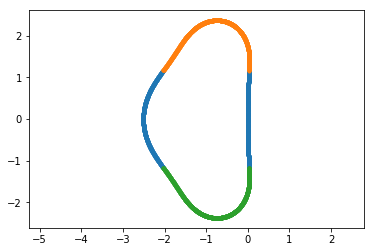

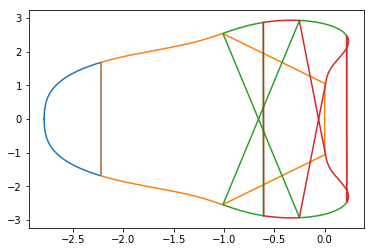

In [12]:
z = sp.symbols("z",complex=True)
theta = sp.symbols("\\theta",real=True)

import math

def poly_carac(N):
  return sum([ sp.Rational(1,(math.factorial(n)))*z**n for n in range(N+1) ])

def b(N):
  p = poly_carac(N)
  bset = sp.solveset(sp.Eq(p,sp.exp(I*theta)),z)
  return [ sp.lambdify(theta,b,'numpy') for b in bset ]

b1 = b(1)
b2 = b(2)
b3 = b(3)
b4 = b(4)

for b in b1:
  tmp = b(data.phi)
  plt.plot(tmp.real,tmp.imag)
plt.axis('equal')
plt.show()

for b in b2:
  tmp = b(data.phi)
  plt.plot(tmp.real,tmp.imag,'.')
plt.axis('equal')
plt.show()

for b in b3:
  tmp = b(data.phi)
  plt.plot(tmp.real,tmp.imag,'.')
plt.axis('equal')
plt.show()

for b in b4:
  tmp = b(data.phi)
  plt.plot(tmp.real,tmp.imag)
#plt.axis('equal')
plt.show()

On remarque que les lignes droites intempestives formées par chaque fonction lorsqu'elle ne représente pas le bord du domaine nuisent à l'analyse en particulier de RK4, c'est à dire le tracer avec les options par défaut de la fonction `plt.plot`, le problème est partiellement résolu en traçant les données à l'aide de points (`plt.plot(x,y,'.')`).

Cela indique que les lignes droites ne font pas partie du résultat (et ne sont qu'un artefact du tracer), par conséquent il est envisageable facilement de stocker tous les points du plan complexe $\mathbb{C}$, de les trier par argument, pour enfin tracer une fonction convenable.

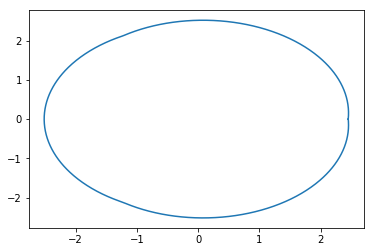

In [13]:
data.reb3sol = []
data.imb3sol = []
for b in b3:
  tmp = b(data.phi)
  data.reb3sol.append(tmp.real)
  data.imb3sol.append(tmp.imag)
  
data.reb2sol = []
data.imb2sol = []
for b in b2:
  tmp = b(data.phi)
  data.reb2sol.append(tmp.real)
  data.imb2sol.append(tmp.imag)
  
btmp = [ math.sqrt(max([ x[i]*x[i] + y[i]*y[i] for (x,y) in zip(data.reb3sol,data.imb3sol) ])) for i in range(len(data.phi)) ]
data.reb = np.cos(data.phi)*btmp
data.imb = np.sin(data.phi)*btmp

plt.plot(data.reb,data.imb)
plt.show()

> **Pourquoi est-ce compliqué de simplifier ceci ?** : car l'argument de $\left(b_i(\theta=0)\right)_{i\in 0,1,2}$ n'est pas le même

Je suis obligé de faire un changement de variable pour avoir le même argument pour tous les $b_i(\theta),\ \forall \theta$ (argument qui, en plus, devrait valoir $\theta$ pour me simplifier la vie).

Et simplement substituer dans $b_1$ et $b_2$ $\theta \gets \theta - \arg(b_0(0))$ ne suffira pas. En plus tous les angles ne sont pas balayés par $b_{1,2}(\theta)$, on le remarque par le fait que la partie imaginaire reste strictement positive ou négative.

L'idéal serait donc de stocker les couples $(|b_i(\theta)|,\arg(b_i(\theta))_{i=0,1,2}\,\forall \theta\in[0,2\pi[$, puis de chercher pour chaque argument le module maximum.

> La méthode proposée est relativement longue à mettre en œuvre. Sachant que l'on atteint les limites de `sympy` dans la simplification de fonction (surtout leur évaluation, il est sans doute possible de forcer l'évaluation, mais cela risque de prendre du temps à calculer) dès que l'on essaie d'effectuer ceci pour le polynôme caractéristique de RK4, il est sans doute plus intéressant d'élaborer une autre méthode.

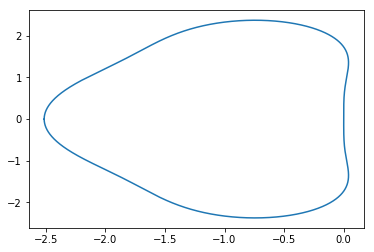

In [14]:
b3curve = []
for b in b3:
  tmp = b(data.phi)
  b3curve.extend(tmp.tolist())
b3curve = sorted(b3curve,key=lambda z: np.angle(z+1))

b3re = [ z.real for z in b3curve ]
b3im = [ z.imag for z in b3curve ]

plt.plot(b3re,b3im)
plt.show()

On arrive *enfin* à tout tracer en une seule fois. On modifie la fonction pour tracer RKn.

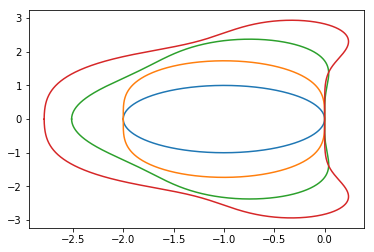

In [15]:
def brk(N):
  p = poly_carac(N)
  bset = sp.solveset(sp.Eq(p,sp.exp(I*theta)),z)
  
  bcurve = []
  for b in [ sp.lambdify(theta,b,'numpy') for b in bset ] :
    tmp = b(data.phi)
    bcurve.extend(tmp.tolist())
  return sorted(bcurve,key=lambda z:np.angle(z+1))

def reim(b):
  return ([z.real for z in b],[z.imag for z in b])

b1 = brk(1)
b2 = brk(2)
b3 = brk(3)
b4 = brk(4)

plt.plot(*reim(b1))
plt.plot(*reim(b2))
plt.plot(*reim(b3))
plt.plot(*reim(b4))
#plt.xlim([-0.1,0.1])
#plt.axis('equal')
plt.show()

### 2.2.1 Petit test en 3D

Il est relativement simple d'évaluer pour une série de point d'une grille la valeur de $|p_3(z_{j,k})|$ avec $z$ définit par :

$$
  z_{j,k} = j\Delta x + i\Delta y
$$

Vu la facilité de la tâche il est relativement simple de répéter l'opération pour différents polynômes caractéristiques $p_N$. Le travail a été effectué pour $N=2,\dots,7$ (sans la moindre analyse des résultats, et avec une grille sans doute très mauvaise). On trace ainsi facilement :

$$
  \{z\in\mathbb{C},|p_N(z)| \leq 1\}
$$

Pour $N=3$, le cas qui nous intéresse, on obtient ainsi :

![Module de $p_3(z)$](rk3.png)

Nous évaluons ici le polynôme en tous les points de la grille, la méthode n'est donc pas viable pour déterminer numériquement avec précision la frontière $|p_N(z)| = 1$ nécessaire dans l'estimation de la CFL $\sigma$.

### 2.2.2 Petit test pour RK5

Je n'arrive pas à trouver avec `sympy` par la même méthode RK5 (problème d'absence de formule analytique pour les racines pour les polynôme de degré supérieur ou égal à 5 ?). Pour obtenir l'ensemble :

$$
  b_5 = \{ z\in\mathbb{C},|p_5(z)| = 1 \}
$$

je dois explorer une autre méthode.

In [16]:
p5 = poly_carac(5)
theta = sp.symbols("\\theta",real=True)
theta = sp.Rational(2,100) # just test for a special value of theta
sp.Poly((p5-sp.exp(I*theta)).evalf(),z,domain="CC")

b5set = sp.solveset(p5-sp.exp(I*theta),z)
#p5-exp(I*theta)

In [17]:
b5set

⎧                                          ⅈ     ⎫
⎪              5    4    3    2            ──    ⎪
⎨             z    z    z    z             50    ⎬
⎪z | z ∊ ℂ ∧ ─── + ── + ── + ── + z + 1 - ℯ   = 0⎪
⎩            120   24   6    2                   ⎭

La seule méthode qui me vient à l'esprit pour résoudre ce problème est de faire ça de manière purement numérique, de manière similaire au travail effectué en 3D. Cela nécessite sans doute une grille très fine (pour un meilleur résultat), en adaptant grossièrement le domaine d'étude en étudiant le polynôme dans $\mathbb{R}$ pour une première estimation du domaine à gauche. On estime que le domaine RKN est contenu vaguement dans un cercle, on obtient ainsi les estimations du domaine en haut et en bas, il n'y a que la limite à droite qu'il faut estimer par une autre méthode.

## 2.3 Étude de stabilité de WENO-RK

On regarde maintenant la stabilité de WENO avec les différents schémas RKN.

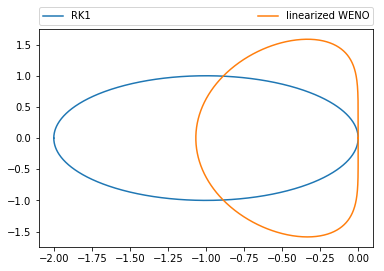

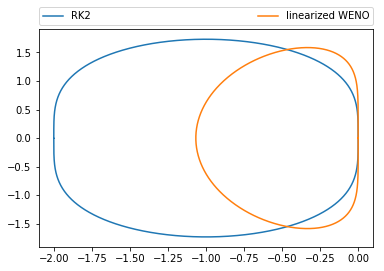

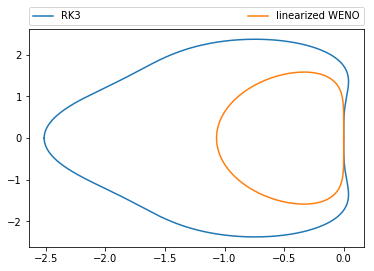

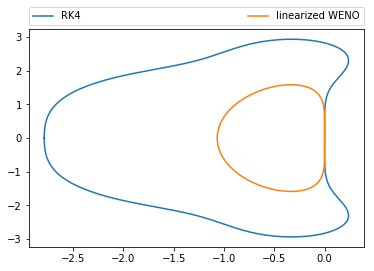

In [166]:
plt.plot(*reim(b1),label="RK1")
plt.plot(-data.rez,data.imz,label="linearized WENO")
#plt.axis('equal')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

plt.plot(*reim(b2),label="RK2")
plt.plot(-data.rez,data.imz,label="linearized WENO")
#plt.axis('equal')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

plt.plot(*reim(b3),label="RK3")
plt.plot(-data.rez,data.imz,label="linearized WENO")
#plt.axis('equal')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

plt.plot(*reim(b4),label="RK4")
plt.plot(-data.rez,data.imz,label="linearized WENO")
#plt.axis('equal')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

### 2.3.1 Automatisation du calcul de CFL

Il est maintenant intéressant d'étudier quel est le rapport d'homothétie liant le mieux RKN à WENO, ce rapport d'homothétie est $\sigma$ le nombre de CFL. Dans le papier de Wang et Spiteri une approximation grossière est faite en supposant que RK$N$, pour $N\geq 3$ contient un rectangle, et l'estimation est ainsi faite d'un $\sigma_0 \leq \sigma$. Ce que l'on se propose de faire numériquement ici est la recherche d'un $\sigma_N$ tel que :

$$
  \sigma_0 \leq \sigma_N \leq \sigma
$$

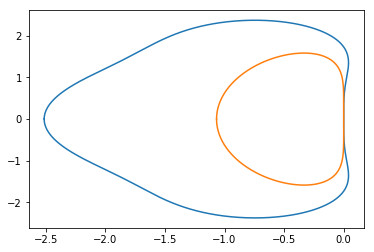

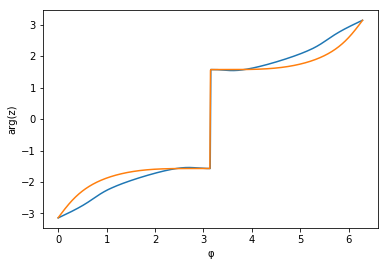

In [90]:
# le tableau b3 est trié par argument (compris dans l'interval [-pi,pi])
# il est plus ou moins nécessaire d'effectuer un travail similaire pour WENO
# reconstruire ztilde de manière similaire à b3 (DONE)

# il est nécessaire de construire des tableaux tels que :
# arg(z[i]+0.5) = arg(b[i]+0.5) ...
# et c'est casse-pied
# le plus simple est de construire les fonction z+0.5 et b+0.5, puis de les évaluer pour tout phi
# et après cette évaluation, trier par argument

ztilde_phi = sp.lambdify(phi,-ztilde_vN,'numpy')(data.phi)
ztilde_ = sorted(ztilde_phi,key=lambda z:np.angle(z+0.5))

sigma = 1 #.433
b3_ = [ b for b in b3[::3] ]
zW_ = [ sigma*z for z in ztilde_ ]
plt.plot(*reim(b3_))
plt.plot(*reim(zW_))

#plt.axis('equal')
#plt.xlim([-0.30,-0.22])
#plt.ylim([-2.25,-2.1])
plt.show()

# avec ce graphique, on peut récupérer pour un phi donné l'argument de b et trouver le
# z correspondant avec le même argument
# une fois cette équivalence effectuée, on peut pour chaque angle calculer :
# b/z, et ainsi trouver le meilleur sigma
plt.plot(data.phi,[np.angle(z) for z in b3_])
plt.plot(data.phi,[np.angle(z) for z in zW_])
plt.xlabel("φ");plt.ylabel("arg(z)")
plt.show()

Détail de l'algorithme à suivre pour avoir 2 tableaux pratiques pour la recherche du $\sigma$ optimal.

1. Tracer $\arg(b^{\text{RK}}(\phi)) = f(\phi)$ et $\arg(\tilde{z}(\phi)) = g(\phi)$
2. Pour chaque valeur $b^{\text{RK}}(\phi_i)$ retrouver l'angle $\varphi_i$ tel que $\arg(b^{\text{RK}}(\phi_i)) = \arg(\tilde{z}(\varphi_i))$. Pour cela, le tableau des valeurs de $b^{\text{RK}}$ et $\tilde{z}$ étant trié par valeur croissante de l'argument, une simple recherche par dichotomie suffit (avec un truc similaire à un `transform_iterator`).
3. Ces deux valeurs :$(b^{\text{RK}}(\phi_i),\tilde{z}(\varphi_i))$ ayant le même argument (ou suffisamment proche), je peux calculer une valeur du nombre de CFL $\varsigma(\phi) = \frac{b^{\text{RK}}(\phi_i)}{\tilde{z}(\varphi_i)}$ pour cette valeur de $\phi_i$ (ou $\varphi_i$ ?). On peut ainsi connaître exactement la valeur de $\Delta t$ pour un $\Delta x$, puisque l'analyse de von Neumann nous donne $\phi = \kappa\Delta x$.
4. Ayant une évaluation de $\varsigma(\phi)$ il est possible de minimiser cette fonction pour connaître le nombre de CFL $\sigma$ indépendant de $\phi$.

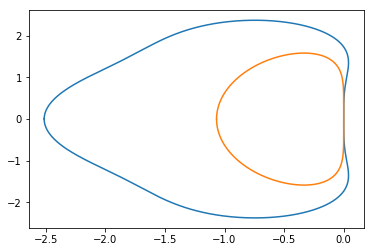

In [91]:
zb = [ min(zW_,key=lambda z:np.abs(np.angle(z)-np.angle(b))) for b in b3_ ]
plt.plot(*reim(b3_))
plt.plot(*reim(zb))
plt.show()
#plt.plot(data.phi,[ (np.angle(z)-np.angle(b)) for (z,b) in zip(zb,b3_) ])
#plt.show()

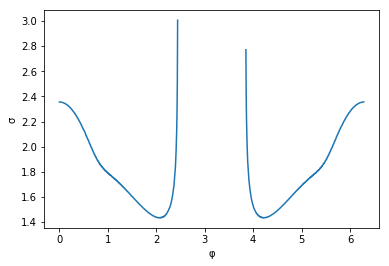

In [92]:
sigs = [ np.abs((b)/(z)) if sp.Abs(z)>1E-2 else float('nan') for (z,b) in zip(zb,b3_) ]
sigma1 = min(sigs[:389])
sigma2 = min(sigs[-388:])
blue = (31/255,119/255,180/255,1)
plt.plot(data.phi,sigs)
plt.xlabel("φ");plt.ylabel("σ")
plt.show()

In [93]:
(sigma1,sigma2,min(sigs))

(1.433683174288281, 1.4339632456328337, 1.433683174288281)

## 2.4 Polynôme caractéristique pour IFRK3

Finalement le travail le plus difficile dans l'étude de la stabilité d'un couple de schémas WENO-temps est l'obtention du polynôme caractérisitique du schéma temporel (travail moins automatisable avec un outil de calcul symbolique que l'analyse de von Neumann du schéma WENO linéarisé), et le tracer de ce polynôme caractérisitique (plus exactement de l'ensemble de points du plan complexe tels que $|p(z)|\leq 1$.

Prenons l'étude d'un schéma temporel un peu plus exotique que RK3, étudions une équation avec un terme *raide* :

$$
  \partial_t u = Lu + N(u)
$$

*Strong stability preserving integrating factor Runge-Kutta methods* propose un schéma RK3-expo :

$$
  \begin{aligned}
    u^{(1)} &= e^{L\Delta t}u^n + e^{L\Delta t}\Delta t N(u^n) \\
    u^{(2)} &= \frac{3}{4}e^{\frac{1}{2}L\Delta t}u^n + \frac{1}{4}e^{-\frac{1}{2}L\Delta t}u^{(1)} + \frac{1}{4}e^{-\frac{1}{2}L\Delta t}\Delta t N(u^{(1)}) \\
    u^{n+1} &= \frac{1}{3}e^{L\Delta t}u^n + \frac{2}{3}e^{\frac{1}{2}L\Delta t}u^{(2)} + \frac{2}{3}e^{\frac{1}{2}L\Delta t}\Delta t N(u^{(2)})
  \end{aligned}
$$

Pour obtenir le polynôme caractéristique d'un schéma *multistage*, il *suffit* d'effectuer la substitution :

* $N(u) \rightarrow \lambda u$ (on linéarise $N$ sur le plan complexe à l'aide d'une variable $\lambda$)
* $\lambda \Delta t \rightarrow z$ (on veut étudier le coefficient d'amplification donné par le produit $\lambda \Delta t$)

On obtient ainsi :

$$
  \begin{aligned}
    u^{(1)} &= e^{L\Delta t}(1+z)u^n \\
    u^{(2)} &= e^{\frac{1}{2}\Delta t}\left(1+\frac{1}{2}z+\frac{1}{4}z^2\right)u^n \\
    u^{n+1} &= e^{L\Delta t}\left(1+z+\frac{1}{2}z^2+\frac{1}{6}z^3\right)u^n
  \end{aligned}
$$

à cause du terme raide linéaire ajouté, il n'est plus possible d'extraire un polynôme caractéristique en une seule variable $z$.

In [23]:
un = sp.symbols("u_n")
L = sp.symbols("L")
dt = sp.symbols("\\Delta\\ t",real=True)
lamb = sp.symbols("\\lambda",complex=True)
z = sp.symbols("z",complex=True)

def N(u):
  """
    non-linéarité (ie WENO)
  """
  return lamb*u

In [24]:
"""
Test de la procédure sur différents RK
RK3 Shu-Osher
"""
u1 = un + dt*N(un)
u2 = sp.Rational(3,4)*un + sp.Rational(1,4)*u1 + sp.Rational(1,4)*dt*N(u1)
un1 = sp.Rational(1,3)*un + sp.Rational(2,3)*u2 + sp.Rational(2,3)*dt*N(u2)

un1.subs(lamb*dt,z).expand().collect(un).collect(z)

   ⎛ 3    2        ⎞
   ⎜z    z         ⎟
uₙ⋅⎜── + ── + z + 1⎟
   ⎝6    2         ⎠

In [25]:
"""
RK3 à 4 étages
"""
u1 = un + sp.Rational(1,2)*dt*N(un)
u2 = u1 + sp.Rational(1,2)*dt*N(u1)
u3 = sp.Rational(2,3)*un + sp.Rational(1,3)*u2 + sp.Rational(1,6)*dt*N(u2)
un1 = u3 + sp.Rational(1,2)*dt*N(u3)

un1.subs(lamb*dt,z).expand().collect(un).collect(z)

   ⎛ 4    3    2        ⎞
   ⎜z    z    z         ⎟
uₙ⋅⎜── + ── + ── + z + 1⎟
   ⎝48   6    2         ⎠

In [26]:
"""RK6"""
nu = sp.symbols("\\nu")
k1 = dt*N(un)
k2 = dt*N(un+nu*k1)
k3 = dt*N(un+( (4*nu-1)*k1 + k2 )/(8*nu))
k4 = dt*N(un+( (10*nu-2)*k1 + 2*k2 + 8*nu*k3 )/(27*nu))
k5 = dt*N(un+( -((77*nu-56)+(17*nu-8)*sp.sqrt(21))*k1
             -8*(7+sp.sqrt(21))*k2 + 48*(7+sp.sqrt(21))*nu*k3
             -3*(21+sp.sqrt(21))*nu*k4 )/(392*nu))
k6 = dt*N(un+( -5*((287*nu-56)-(59*nu-8)*sp.sqrt(21))*k1
             -40*(7-sp.sqrt(21))*k2 + 320*sp.sqrt(21)*nu*k3 + 3*(21-121*sp.sqrt(21))*nu*k4
             + 392*(6-sp.sqrt(21))*nu*k5)/(1960*nu))
k7 = dt*N(un+( 15*((30*nu-8)-(7*nu*sp.sqrt(21)))*k1 + 120*k2
             - 40*(5+7*sp.sqrt(21))*nu*k3 + 63*(2+3*sp.sqrt(21))*nu*k4
             - 14*(49-9*sp.sqrt(21))*nu*k5 + 70*(7+sp.sqrt(21))*nu*k6)/(180*nu))

un1 = un + (9*k1 + 64*k3 + 49*k5 + 49*k6 + 9*k7)/180
un1.subs(lamb*dt,z).simplify().expand().collect(un).collect(z).collect(nu)

   ⎛    7      6     5    4    3    2        ⎞
   ⎜   z      z     z    z    z    z         ⎟
uₙ⋅⎜- ──── + ─── + ─── + ── + ── + ── + z + 1⎟
   ⎝  2160   720   120   24   6    2         ⎠

In [46]:
poly_carac(7)*un

   ⎛  7      6     5    4    3    2        ⎞
   ⎜ z      z     z    z    z    z         ⎟
uₙ⋅⎜──── + ─── + ─── + ── + ── + ── + z + 1⎟
   ⎝5040   720   120   24   6    2         ⎠

In [28]:
"""
RK3 exponentiel basé sur la méthode de Shu-Osher
"""
u1 = sp.exp(L*dt)*un + sp.exp(L*dt)*dt*N(un)
u2 = ( sp.Rational(3,4)*sp.exp(sp.Rational(1,2)*L*dt)*un + sp.Rational(1,4)*sp.exp(-sp.Rational(1,2)*L*dt)*u1
      + sp.Rational(1,4)*sp.exp(-sp.Rational(1,2)*L*dt)*dt*N(u1) )
un1 = ( sp.Rational(1,3)*sp.exp(L*dt)*un + sp.Rational(2,3)*sp.exp(sp.Rational(1,2)*L*dt)*u2
       + sp.Rational(2,3)*sp.exp(sp.Rational(1,2)*L*dt)*dt*N(u2) )
un1.subs(lamb*dt,z).expand().collect(z).collect(un).collect(sp.exp(L*dt))

   ⎛ 3    2        ⎞            
   ⎜z    z         ⎟  L⋅\Delta t
uₙ⋅⎜── + ── + z + 1⎟⋅ℯ          
   ⎝6    2         ⎠            

In [123]:
"""
même travail pour une version sans pas de temps négatif dans les étages intermédiaires
"""

u1 = ( sp.Rational(1,2)*sp.exp(sp.Rational(2,3)*dt*L)*un
      + sp.Rational(1,2)*sp.exp(sp.Rational(2,3)*dt*L)*(un + sp.Rational(4,3)*dt*N(un)) )
u2 = ( sp.Rational(2,3)*sp.exp(sp.Rational(2,3)*dt*L)*un
      + sp.Rational(1,3)*(u1 + sp.Rational(4,3)*dt*N(u1)) )
un1 = ( sp.Rational(59,128)*sp.exp(dt*L)*un
       + sp.Rational(15,128)*sp.exp(dt*L)*(un + sp.Rational(4,3)*dt*N(un))
      + sp.Rational(27,64)*sp.exp(sp.Rational(1,3)*dt*L)*( u2 + sp.Rational(4,3)*dt*N(u2) ) )

un1.subs(lamb*dt,z).expand().collect(un).collect(sp.exp(L*dt)).collect(z)

   ⎛ 3    2        ⎞            
   ⎜z    z         ⎟  L⋅\Delta t
uₙ⋅⎜── + ── + z + 1⎟⋅ℯ          
   ⎝6    2         ⎠            

In [39]:
 poly_carac(4)*un

   ⎛ 4    3    2        ⎞
   ⎜z    z    z         ⎟
uₙ⋅⎜── + ── + ── + z + 1⎟
   ⎝24   6    2         ⎠

Dans le cas $L\in i\mathbb{R}$ (on souhaite prendre $L=iv\kappa$) cela ne pose pas réellement de problème puisque $\left|e^{L\Delta t}\right| = 1,\forall\Delta t$ (nous souhaitons étudier le module du polynôme caractéristique). Cela pose plus de problèmes dans le cas général puisque le module de l'exponentielle est alors : $e^{\Delta t\mathfrak{R}(L)}$. En plus d'être potentiellement plus compliqué à étudie car faisant intervenir un autre $\Delta t$ qui n'a pas été absorbé par un $z$, cela signifie que la stabilité du schéma dépend de $L$ (donc de notre discrétisation spatiale).

# 3. Analyse de propagation des incertitudes

Il peut aussi être intéressant d'étudier la propagation des incertitudes dans un schéma WENO. Dans le cas d'une simulation d'un cas test *jouet* les incertitudes attendues sont plus celles liées aux erreurs de troncature dans l'algèbre des nombres à virgule flottante.

In [31]:
"""
  exact symbolic complet WENO flux
"""

IS0p = sp.Rational(13,12)*( f(-2) - 2*f(-1) + f(+0) )**2 + sp.Rational(1,4)*(   f(-2) - 4*f(-1) + 3*f(+0) )**2
IS1p = sp.Rational(13,12)*( f(-1) - 2*f(+0) + f(+1) )**2 + sp.Rational(1,4)*(   f(-1) -   f(+1) )**2
IS2p = sp.Rational(13,12)*( f(+0) - 2*f(+1) + f(+2) )**2 + sp.Rational(1,4)*( 3*f(+0) - 4*f(+1) +   f(+2) )**2

epsilon = sp.symbols("\\epsilon")
dx = sp.symbols("\\Delta\\ x",real=True)

a0p = sp.Rational(1,10)*(1/(epsilon+IS0p))**2
a1p = sp.Rational(6,10)*(1/(epsilon+IS1p))**2
a2p = sp.Rational(3,10)*(1/(epsilon+IS2p))**2

w0p = a0p/(a0p+a1p+a2p)
w1p = a1p/(a0p+a1p+a2p)
w2p = a2p/(a0p+a1p+a2p)

IS0m = sp.Rational(13,12)*( f(+1) - 2*f(+2) + f(+3) )**2 + sp.Rational(1,4)*( 3*f(+1) - 4*f(+2) +   f(+3) )**2
IS1m = sp.Rational(13,12)*( f(+0) - 2*f(+1) + f(+2) )**2 + sp.Rational(1,4)*(   f(+0) -   f(+2) )**2
IS2m = sp.Rational(13,12)*( f(-1) - 2*f(+0) + f(+1) )**2 + sp.Rational(1,4)*(   f(-1) - 4*f(+0) + 3*f(+1) )**2

a0m = sp.Rational(1,10)*(1/(epsilon+IS0m))**2
a1m = sp.Rational(6,10)*(1/(epsilon+IS1m))**2
a2m = sp.Rational(3,10)*(1/(epsilon+IS2m))**2

w0m = a0m/(a0m+a1m+a2m)
w1m = a1m/(a0m+a1m+a2m)
w2m = a2m/(a0m+a1m+a2m)

fjp12p = (w0p*( sp.Rational(2,6)*f(-2) - sp.Rational(7,6)*f(-1) + sp.Rational(11,6)*f(+0) )
        + w1p*(-sp.Rational(1,6)*f(-1) + sp.Rational(5,6)*f(+0) +  sp.Rational(2,6)*f(+1) )
        + w2p*( sp.Rational(2,6)*f(+0) + sp.Rational(5,6)*f(+1) -  sp.Rational(1,6)*f(+2) ))
fjm12p = fjp12p.subs(symbols_to(f_stencil, lambda j,_:f(j-1)),simultaneous=True)

fjp12m = (w2m*(-sp.Rational(1,6)*f(-1) + sp.Rational(5,6)*f(+0) + sp.Rational(2,6)*f(+1) )
        + w1m*(-sp.Rational(2,6)*f(+0) + sp.Rational(5,6)*f(+1) - sp.Rational(1,6)*f(+2) )
        + w0m*(sp.Rational(11,6)*f(+1) - sp.Rational(7,6)*f(+2) + sp.Rational(2,6)*f(+3) ))
fjm12m = fjp12m.subs(symbols_to(f_stencil, lambda j,_:f(j-1)),simultaneous=True)

dxu = (fjp12p - fjm12p) + (fjp12m - fjm12m)

La variable `dxu` est une approximation de $(\partial_x u)_{|x=x_j}$ par le schéma WENO5 (plus exactement le flux complet de $\partial_x u$ par le schéma WENO5, car il manque la division par $\Delta x$).
La notation de $u$ et $f$ est issu de l'article de Wang et Spiteri.

Ce que je souhaite étudier est l'impact d'une faible variation sur la connaissance de $\left(f_{j+k}\right)_{k\in [\![-3,3]\!]}$.

Plusieurs stratégies sont adoptable :

* Supposer que chaque $\left(f_{j+k}\right)_{k\in [\![-3,3]\!]}$ est donnée par une variable aléatoire (on prend une normale en première approche, par la suite les paramètres de cette distribution de probablité peuvent varier à mesure des connaissances sur l'algèbre des nombres à virgule flottante car les états possibles ne sont pas linéairement distribués), et d'estimer la variance de la variable aléatoire donnée par l'approximation de $(\partial_x u)_{|x=x_j}$ par le schéma WENO.
* Méthode bien plus calculatoire en ajoutant un écart pour chaque donnée d'entrée et d'obtenir une fonction à 7 variables. Cela permet de mesurer l'importance de chaque terme sur le résultat final.

In [159]:
import sympy as sp
from sympy import stats
mu = sp.symbols("\\mu",real=True)
va = sp.symbols("\\sigma",real=True,positive=True)
x  = sp.symbols("x",real=True,positive=True)
X = sp.stats.Normal("X",f(0),va)
Y = sp.stats.Normal("Y",f(1),va)
sp.stats.density(X)(x)

               2 
    -(-f_j + x)  
    ─────────────
              2  
      2⋅\sigma   
√2⋅ℯ             
─────────────────
   2⋅√π⋅\sigma   